In [20]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler #samples randomly from given indices
from torch.utils.data.dataloader import DataLoader # loads the data from sampler
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.11.0+cu113


In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [13]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [14]:
class_names = ['normal', 'covid']
root_dir = '/content/gdrive/MyDrive/Python/PyTorch_binary_classification/data/'
source_dirs = ['normal', 'covid']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 100)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal','covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [5]:
#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [6]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
train_dirs = {
    'normal': "/content/gdrive/MyDrive/Python/PyTorch_binary_classification/data/normal",
    'covid': "/content/gdrive/MyDrive/Python/PyTorch_binary_classification/data/covid"

}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10062 normal examples
Found 3486 covid examples


In [16]:
test_dirs = {
    'normal': "/content/gdrive/MyDrive/Python/PyTorch_binary_classification/data/test/normal",
    'covid': "/content/gdrive/MyDrive/Python/PyTorch_binary_classification/data/test/covid"

}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 100 normal examples
Found 100 covid examples


Поделим train_data на train и validation выборки

In [18]:
# Splitting the data into train and validation set
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  # Here indices are randomly permuted 
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

train_indices,validation_indices=split_train_val(len(train_dataset))
print(validation_indices[:5])

[ 1380  9792 10057  5037  4125]


In [21]:
# Subset random sampler takes the indices to pick the data
# dataloader loads with the main dataset, with batch size and the sampler object
batch_size=16
# Training Part
train_sampler=SubsetRandomSampler(train_indices)
train_ds=DataLoader(train_dataset,batch_size,sampler=train_sampler)

# Validation Part
val_sampler=SubsetRandomSampler(validation_indices)
val_ds=DataLoader(train_dataset,batch_size,sampler=val_sampler)

In [22]:
print('Number of training batches', len(train_ds))
print('Number of test batches', len(val_ds))

Number of training batches 678
Number of test batches 170


In [18]:
batch_size = 16
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 835
Number of test batches 25


In [23]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(18, 14))
    for i, image in enumerate(images):
        plt.subplot(1, batch_size, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

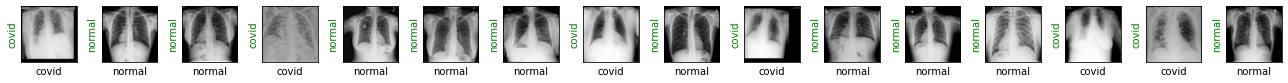

In [25]:

images, labels = next(iter(train_ds))
show_images(images, labels, labels)

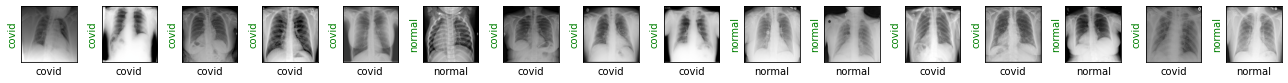

In [27]:
images, labels = next(iter(val_ds))
show_images(images, labels, labels)

In [28]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [29]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [30]:
def show_preds(dataset):
    resnet18.eval()
    images, labels = next(iter(dataset))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

In [24]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

          train_loss /= (train_step + 1)

          print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [37]:
def train(train_dataset, val_dataset,epochs):
    print("Starting training...")
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch{e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(train_dataset):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print("Evaluating at step", train_step)
                acc = 0.    #accuracy
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(val_dataset):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _,preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                acc = acc/len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                
                resnet18.train()
                
                if acc > 0.95:
                    print('Performance condition satified...')
                    return 
            train_loss /= (train_step + 1)
            print(f'Training loss: {train_loss:.4f}')

In [38]:
%%time

train( train_ds, val_ds,epochs=1,)

Starting training...
Starting epoch1/1
Evaluating at step 0
Val loss: 0.6942, Acc: 7.4400
Performance condition satified...
CPU times: user 3min 33s, sys: 3.43 s, total: 3min 36s
Wall time: 18min 31s
